# Inclusion Stress Field Prediction

Импортируем библиотеки:

In [1]:
import os
import glob

import cv2

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import transforms, models

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
torch.manual_seed(42)
cudnn.deterministic = True
cudnn.benchmark = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Обозначим константы:

In [2]:
#Model Constants
IMAGE_SIZE = 256
BATCH_SIZE = 5
LEARNING_RATE = 1e-3
EPOCH = 100

Основные пути к папкам, откуда мы будем брать исходные данные для данного проекта:

In [3]:
path_folder = 'S:/abaqus_job_files/plot\\'
path_table = 'S:/abaqus_job_files/stresses_data/general_array.csv'

## Работа с табличными данными

In [4]:
def data_preparation(path, path_csv):
    
    stress_data_columns = ['max_s11', 'min_s11',
                           'max_s22', 'min_s22',
                           'max_s12', 'min_s12']
    
    stress_components = ['s11', 's22', 's12', 'geom']
    
    #read data
    df = pd.read_csv(path_csv, delimiter=' ', header=0).round(2)
    df.index += 1
    
    for i in stress_components:

        raw_images = sorted(glob.glob(path + '/*' + i + '*'), key=len)
        df['images_' + i] = raw_images
        
    df_train, df_valid = train_test_split(df,
                                          train_size=.6,
                                          random_state=1,
                                          shuffle=True)

    df_valid, df_test = train_test_split(df_valid,
                                         train_size=.5,
                                         random_state=1,
                                         shuffle=True)
    
    print(f'Train shape: {df_train.shape[0]}')
    print(f'Valid shape: {df_valid.shape[0]}')
    print(f'Test shape: {df_test.shape[0]}')
        
    return df_train, df_valid, df_test

Разделим данные на тренировочную, валидационную и тестовую выборки.

In [5]:
df_train, df_valid, df_test = data_preparation(path_folder, path_table)

Train shape: 600
Valid shape: 200
Test shape: 200


In [6]:
df_train.head()

,max_s11,min_s11,max_s22,min_s22,max_s12,min_s12,images_s11,images_s22,images_s12,images_geom
372,135.11,72.91,144.56,73.08,28.33,-31.51,S:/abaqus_job_files/plot\372_s11.png,S:/abaqus_job_files/plot\372_s22.png,S:/abaqus_job_files/plot\372_s12.png,S:/abaqus_job_files/plot\372_geom.png
46,143.97,74.41,134.32,73.88,26.38,-28.07,S:/abaqus_job_files/plot\46_s11.png,S:/abaqus_job_files/plot\46_s22.png,S:/abaqus_job_files/plot\46_s12.png,S:/abaqus_job_files/plot\46_geom.png
561,135.99,72.18,159.40,71.83,31.32,-25.88,S:/abaqus_job_files/plot\561_s11.png,S:/abaqus_job_files/plot\561_s22.png,S:/abaqus_job_files/plot\561_s12.png,S:/abaqus_job_files/plot\561_geom.png
749,158.86,67.89,184.35,65.88,35.51,-46.56,S:/abaqus_job_files/plot\749_s11.png,S:/abaqus_job_files/plot\749_s22.png,S:/abaqus_job_files/plot\749_s12.png,S:/abaqus_job_files/plot\749_geom.png
420,149.66,68.62,160.03,69.02,36.85,-36.53,S:/abaqus_job_files/plot\420_s11.png,S:/abaqus_job_files/plot\420_s22.png,S:/abaqus_job_files/plot\420_s12.png,S:/abaqus_job_files/plot\420_geom.png


## EDA

Оценим распределение представленных величин.

In [7]:
def kde_plot(data_list, columns):
    
    fig, ax = plt.subplots(2, 3, figsize=(13, 9))
    
    for data in data_list:
        for column, i, j in zip(columns, [0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]):
            
            sns.kdeplot(x=column,
                        data=data,
                        shade=True,
                        ax=ax[i, j])
            
            if j == 0:
                ax[i, j].set_ylabel('Density', fontsize=12)
            else:
                ax[i, j].set_ylabel('')
                
            ax[i, j].set_xlabel(f'{column}')
            ax[i, j].set_title(f'KDE of {column}')
            ax[i, j].legend(['Train', 'Valid', 'Test'])
    
    fig.suptitle('Kernel density estimation of presented variables', fontsize=18)
    fig.tight_layout()
    plt.show()

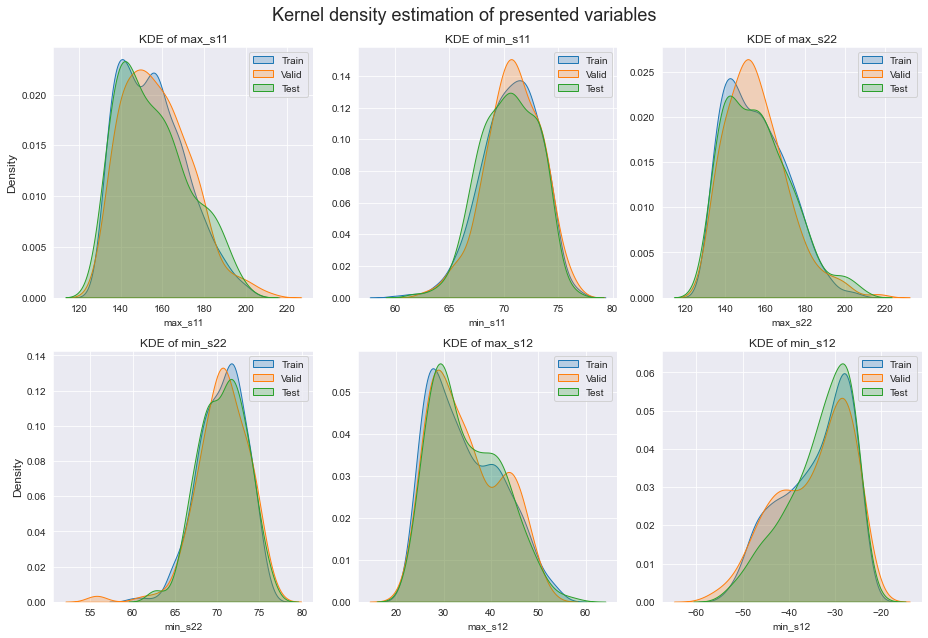

In [8]:
kde_plot([df_train, df_valid, df_test],
         ['max_s11', 'min_s11','max_s22', 'min_s22','max_s12', 'min_s12'])

Распределения всех представленных величин крайне схожи по своей форме для различных наборов данных - тренировочного, валидационного и тестового датасетов.

## Загрузчик данных

Напишем загрузчик данных, который сможет выгружать датасеты по отдельным компонентам.

In [9]:
class Stress_dataset(torch.utils.data.Dataset):
    
    def __init__(self, df, component, transform=False):
        
        columns_mask = [component in column for column in df.columns]
        columns_mask[-1] = True
        columns = df.columns[columns_mask]
        
        self.df = df[columns]
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        #geometry preprocessing
        geometry = cv2.imread(self.df.iloc[index, -1], cv2.IMREAD_GRAYSCALE)
        #crop
        geometry = geometry[20:780, 331:1092]
        #resize
        geometry = cv2.resize(geometry, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        #normalize
        #geometry = (255 - geometry)
        geometry = cv2.threshold(geometry, 127, 255, cv2.THRESH_BINARY)[1]
        geometry = geometry / 255
        #add additional dimension
        geometry = np.array([geometry])
          
        result = cv2.imread(self.df.iloc[index, -2], cv2.IMREAD_GRAYSCALE)
        #crop
        result = result[118:637, 523:1043]
        #resize image
        result = cv2.resize(result, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        #normolize between 0 and 1
        result = result / 255
        
        #normalize between min and max stresses
        result = cv2.normalize(
            result, None, alpha=self.df.iloc[index, 1], beta=self.df.iloc[index, 0], norm_type=cv2.NORM_MINMAX
        )
        result = np.array([result])
        
        #convert to torch.Tensor
        geometry = torch.from_numpy(geometry.copy()).type(torch.float32)
        result = torch.from_numpy(result.copy()).type(torch.float32)
        
        return (geometry, result)

Начнем работу с компоненты тензора напряжений - $\bf{\sigma_{11}}$.

In [10]:
train_dataset_s11 = Stress_dataset(df_train, 's11')
valid_dataset_s11 = Stress_dataset(df_valid, 's11')
test_dataset_s11 = Stress_dataset(df_test, 's11')

In [11]:
train_dataloader_s11 = torch.utils.data.DataLoader(train_dataset_s11, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader_s11 = torch.utils.data.DataLoader(valid_dataset_s11, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader_s11 = torch.utils.data.DataLoader(test_dataset_s11, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
def image_show_tensor(dataloader, number_of_images=3, initial_index=0):
    
    masks, images = next(iter(dataloader))

    fig = plt.figure(figsize=(20, 20))
    
    for tensor in [masks, images]:
        
        tensor = tensor.numpy().transpose(0,2,3,1)
        
        fig = plt.figure(figsize=(20, 20))
        
        for i in range(number_of_images):

            fig.add_subplot(1, number_of_images+1, i+1)
            plt.imshow(tensor[i+initial_index], cmap='viridis_r')
            
            min = (tensor[i+initial_index]).min()
            max = (tensor[i+initial_index]).max()

            plt.clim(min, max)
            plt.colorbar(shrink=0.2015)
            
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

<Figure size 1440x1440 with 0 Axes>

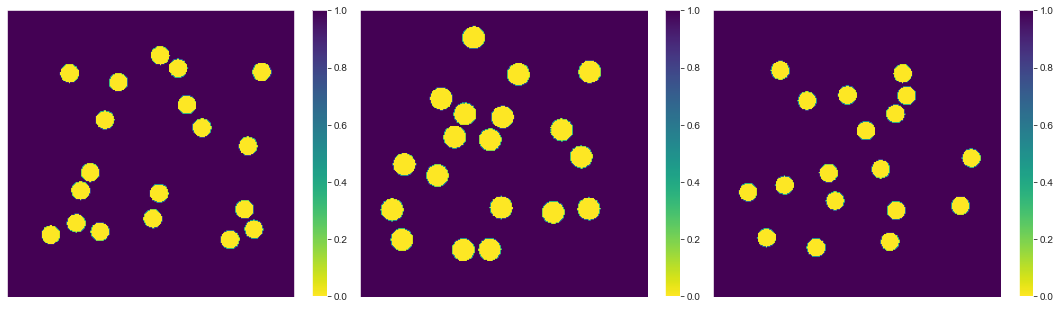

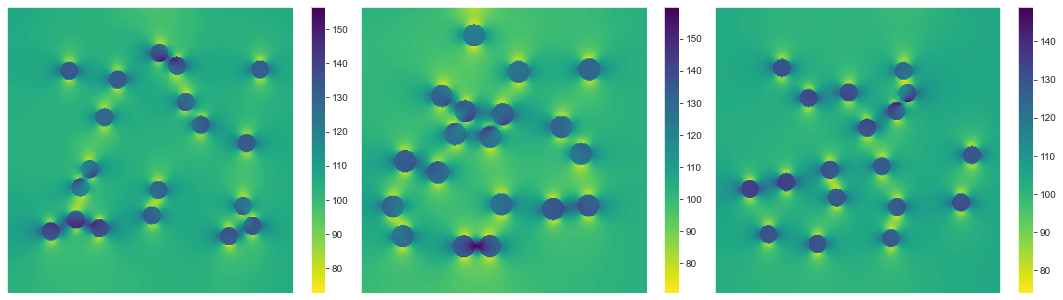

In [13]:
image_show_tensor(train_dataloader_s11)

## Модель 

Определим **дискриминатор**.

In [14]:
class Discriminator(nn.Module):
    """Discriminator Network"""
    def __init__(self):
        super(Discriminator, self).__init__()

        self.in_channels = 1
        self.ndf = 64
        self.out_channels = 1

        self.main = nn.Sequential(
            nn.Conv2d(self.in_channels * 2, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 128

            nn.Conv2d(self.ndf, self.ndf*2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ndf*2),
            # 64 x 64

            nn.Conv2d(self.ndf*2, self.ndf*4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ndf*4),
            # 32 x 32

            nn.Conv2d(self.ndf*4, self.ndf*8, 4, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ndf*8),
            # 31 x 31

            nn.Conv2d(self.ndf*8, self.out_channels, 4, 1, 1, bias=False),
            # 30 x 30 (PatchGAN)
            nn.Sigmoid()
        )

    def forward(self, x, label):
        
        out = torch.cat((x, label), dim=1)
        out = self.main(out)
        
        return out

И **генератор**.

In [15]:
class Generator(nn.Module):
    """Generator Network"""
    def __init__(self):
        super(Generator, self).__init__()

        self.input_dim = 1
        self.ngf = 64
        self.output_dim = 1

        self.conv1 = nn.Sequential(
            nn.Conv2d(self.input_dim, self.ngf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.ngf, self.ngf*2, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(self.ngf*2, self.ngf*4, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*4)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(self.ngf*4, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )

        self.conv8 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )

        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )

        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )

        self.deconv5 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*4, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*4),
            nn.ReLU(inplace=True)
        )

        self.deconv6 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*8, self.ngf*2, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*2),
            nn.ReLU(inplace=True)
        )

        self.deconv7 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*4, self.ngf, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf),
            nn.ReLU(inplace=True)
        )

        self.deconv8 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*2, self.output_dim, 4, 2, 1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)

        dec1 = torch.cat([self.deconv1(enc8), enc7], dim=1)
        dec2 = torch.cat([self.deconv2(dec1), enc6], dim=1)
        dec3 = torch.cat([self.deconv3(dec2), enc5], dim=1)
        dec4 = torch.cat([self.deconv4(dec3), enc4], dim=1)
        dec5 = torch.cat([self.deconv5(dec4), enc3], dim=1)
        dec6 = torch.cat([self.deconv6(dec5), enc2], dim=1)
        dec7 = torch.cat([self.deconv7(dec6), enc1], dim=1)
        out = self.deconv8(dec7)

        return out

In [16]:
def set_requires_grad(network, requires_grad=False):
    """Prevent a Network from Updating"""
    for param in network.parameters():
        param.requires_grad = requires_grad

In [17]:
D = Discriminator().to(device)
G = Generator().to(device)

Определим **loss**-функцию и **optimizer**.

In [18]:
criterion_Adversarial = nn.BCELoss()
criterion_Pixelwise = nn.L1Loss()

In [19]:
D_optim = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.999))
G_optim = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.999))

## Обучение

In [20]:
G_train_loss_history, G_valid_loss_history, G_test_loss_history = [], [], []
D_train_loss_history, D_valid_loss_history, D_test_loss_history = [], [], []

for epoch in range(EPOCH):
    
    G_train_batch_loss_history, G_valid_batch_loss_history, G_test_batch_loss_history = [], [], []
    D_train_batch_loss_history, D_valid_batch_loss_history, D_test_batch_loss_history = [], [], []
    
    #train
    for geometry, result in train_dataloader_s11:
        
        D_optim.zero_grad()
        G_optim.zero_grad()
        
        geometry = geometry.to(device, dtype=torch.float)
        result = result.to(device, dtype=torch.float)
        
        set_requires_grad(D, requires_grad=False)
        
        #Train Generator
        fake_result = G(geometry)
        prob_fake = D(fake_result, geometry)
        real_labels = torch.ones(prob_fake.size()).to(device)
        G_loss_fake = criterion_Adversarial(prob_fake, real_labels)
        
        G_loss_pixelwise = criterion_Pixelwise(fake_result, result)
        
        G_loss = G_loss_fake + G_loss_pixelwise
        G_train_batch_loss_history.append(G_loss.item())
        
        G_loss.backward()
        G_optim.step()
        
        #Train Discriminator
        set_requires_grad(D, requires_grad=True)
        
        prob_real = D(result, geometry)
        real_labels = torch.ones(prob_real.size()).to(device)
        D_real_loss = criterion_Adversarial(prob_real, real_labels)
        
        fake_result = G(geometry)
        prob_fake = D(fake_result.detach(), geometry)
        fake_labels = torch.zeros(prob_fake.size()).to(device)
        D_fake_loss = criterion_Adversarial(prob_fake, fake_labels)
        
        D_loss = torch.mean(D_real_loss + D_fake_loss)
        D_train_batch_loss_history.append(D_loss.item())
        
        D_loss.backward()
        D_optim.step()
        
        del geometry, result, fake_labels, real_labels
        torch.cuda.empty_cache()
        
    #valid    
    for geometry, result in valid_dataloader_s11:
        
        geometry = geometry.to(device, dtype=torch.float)
        result = result.to(device, dtype=torch.float)
        
        fake_result = G(geometry)
        prob_fake = D(fake_result, geometry)
        real_labels = torch.ones(prob_fake.size()).to(device)
        G_loss_fake = criterion_Adversarial(prob_fake, real_labels)
        
        G_loss_pixelwise = criterion_Pixelwise(fake_result, result)
        
        G_loss = G_loss_fake + G_loss_pixelwise
        G_valid_batch_loss_history.append(G_loss.item())
        
        prob_real = D(result, geometry)
        real_labels = torch.ones(prob_real.size()).to(device)
        D_real_loss = criterion_Adversarial(prob_real, real_labels)
        
        fake_result = G(geometry)
        prob_fake = D(fake_result.detach(), geometry)
        fake_labels = torch.zeros(prob_fake.size()).to(device)
        D_fake_loss = criterion_Adversarial(prob_fake, fake_labels)
        
        D_loss = torch.mean(D_real_loss + D_fake_loss)
        D_valid_batch_loss_history.append(D_loss.item())
        
        del geometry, result, fake_labels, real_labels
        torch.cuda.empty_cache()
    
    #test
    for geometry, result in test_dataloader_s11:
        
        geometry = geometry.to(device, dtype=torch.float)
        result = result.to(device, dtype=torch.float)
        
        fake_result = G(geometry)
        prob_fake = D(fake_result, geometry)
        real_labels = torch.ones(prob_fake.size()).to(device)
        G_loss_fake = criterion_Adversarial(prob_fake, real_labels)
        
        G_loss_pixelwise = criterion_Pixelwise(fake_result, result)
        
        G_loss = G_loss_fake + G_loss_pixelwise
        G_test_batch_loss_history.append(G_loss.item())
        
        prob_real = D(result, geometry)
        real_labels = torch.ones(prob_real.size()).to(device)
        D_real_loss = criterion_Adversarial(prob_real, real_labels)
        
        fake_result = G(geometry)
        prob_fake = D(fake_result.detach(), geometry)
        fake_labels = torch.zeros(prob_fake.size()).to(device)
        D_fake_loss = criterion_Adversarial(prob_fake, fake_labels)
        
        D_loss = torch.mean(D_real_loss + D_fake_loss)
        D_test_batch_loss_history.append(D_loss.item())
        
        del geometry, result, fake_labels, real_labels
        torch.cuda.empty_cache()
        
    G_train_loss = np.mean(G_train_batch_loss_history)
    G_train_loss_history.append(G_train_loss)
    D_train_loss = np.mean(D_train_batch_loss_history)
    D_train_loss_history.append(D_train_loss)
    
    G_valid_loss = np.mean(G_valid_batch_loss_history)
    G_valid_loss_history.append(G_valid_loss)
    D_valid_loss = np.mean(D_valid_batch_loss_history)
    D_valid_loss_history.append(D_valid_loss)
    
    G_test_loss = np.mean(G_test_batch_loss_history)
    G_test_loss_history.append(G_test_loss)
    D_test_loss = np.mean(D_test_batch_loss_history)
    D_test_loss_history.append(D_test_loss)

    if epoch % 2 == 0:
        print(
            f'{epoch} | D Train:{D_train_loss:.4f} | G Train:{G_train_loss:.4f} | D Valid:{D_valid_loss:.4f} | G Valid:{G_valid_loss:.4f} | D Test:{D_test_loss:.4f} | G Test:{G_test_loss:.4f}'
        )

0 | D Train:0.5470 | G Train:64.5077 | D Valid:0.0117 | G Valid:12.1322 | D Test:0.0116 | G Test:12.0656
2 | D Train:1.2901 | G Train:5.2390 | D Valid:1.4119 | G Valid:6.0839 | D Test:1.4098 | G Test:6.0245
4 | D Train:0.8510 | G Train:5.6906 | D Valid:0.3614 | G Valid:5.1726 | D Test:0.3625 | G Test:5.2087
6 | D Train:0.5198 | G Train:6.5182 | D Valid:0.1435 | G Valid:6.3596 | D Test:0.1410 | G Test:6.2706
8 | D Train:0.5874 | G Train:6.7268 | D Valid:0.2261 | G Valid:6.4466 | D Test:0.2153 | G Test:6.6314
10 | D Train:0.6641 | G Train:6.0982 | D Valid:1.4634 | G Valid:3.4622 | D Test:1.5092 | G Test:3.3592
12 | D Train:0.7620 | G Train:5.8045 | D Valid:0.2879 | G Valid:4.7304 | D Test:0.2906 | G Test:4.7601
14 | D Train:0.5518 | G Train:6.0545 | D Valid:0.1647 | G Valid:5.6244 | D Test:0.1727 | G Test:5.4418
16 | D Train:0.6805 | G Train:5.6175 | D Valid:1.4182 | G Valid:7.6097 | D Test:1.3759 | G Test:7.5079
18 | D Train:0.5534 | G Train:5.8656 | D Valid:0.2050 | G Valid:5.6390 | D 

## Результаты 

Отдельно сохраним результаты обучения модели.

In [21]:
dict_data = {'G train loss' : G_train_loss_history,
             'G valid loss' : G_valid_loss_history,
             'G test loss' : G_test_loss_history,
             'D train loss' : D_train_loss_history,
             'D valid loss' : D_valid_loss_history,
             'D test loss' : D_test_loss_history}

In [22]:
df_results = pd.DataFrame.from_dict(dict_data)
#df_results.to_csv('S:/abaqus_job_files/results_data/loss_results_s11', sep=' ')

In [23]:
def loss_plot(data):
    
    generator_loss_names = data.columns[:3]
    discriminator_loss_names = data.columns[3:]
    legend_names = ['Train', 'Valid', 'Test']
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, j, k in zip(generator_loss_names, discriminator_loss_names, legend_names):
        
        ax[0].plot(data[i].values, label=k)
        ax[1].plot(data[j].values, label=k)
        
    for i, j in enumerate(['Generator', 'Discriminator']):

        ax[i].set_title(f'{j} Loss Plot', fontsize=14)
        ax[i].set_xlabel('Epoch', fontsize=12)
        ax[i].set_ylabel(f'{j} Loss Function Value', fontsize=12)
        ax[i].legend()
        
    fig.suptitle('Loss functions plot for $\sigma_{11}$', fontsize=18)
    plt.show()

Визуализируем значения функции потерь для каждого из датасетов.

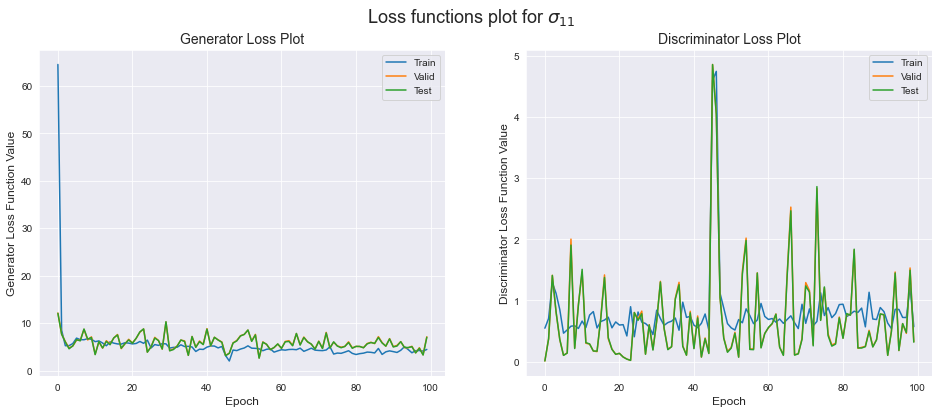

In [24]:
loss_plot(df_results)

Визуально оценим результаты работы алгоритма.

In [25]:
def singular_result(dataloader, model=G, initial_index=0, cmap='viridis', component='$\sigma_{11}$'):
    
    model = model.cpu()
    geometry, result = next(iter(dataloader))

    prediction = model(geometry.float())
    error = abs(result - prediction)

    tensors = [geometry, result, prediction, error]
    titles = ['Geometry', f'True {component} field', f'Predicted {component} field', '$L_{1}$ error']
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    
    for tensor, title, i, j in zip(tensors, titles, [0, 0, 1, 1], [0, 1, 0, 1]): 
        
        tensor = tensor.cpu().detach().numpy().transpose(0,2,3,1)
        
        if i == 0 and j == 0:
            img = ax[i, j].imshow(tensor[initial_index], cmap='Greys_r')
        elif i != j:
            img = ax[i, j].imshow(tensor[initial_index], cmap=cmap)
        else:
            img = ax[i, j].imshow(tensor[initial_index], cmap='icefire')
            
        ax[i, j].set_title(title, fontsize=14)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
        min = (tensor[initial_index]).min()
        max = (tensor[initial_index]).max()
        
        if i == 1 and j == 1:
            img.set_clim(0, max)
        else:
            img.set_clim(min, max)
            
        plt.colorbar(img, shrink=0.815, ax=ax[i, j])
            
    fig.suptitle(f'Visualization for the one sample of {component}', fontsize=18)
    fig.tight_layout()
    plt.show()

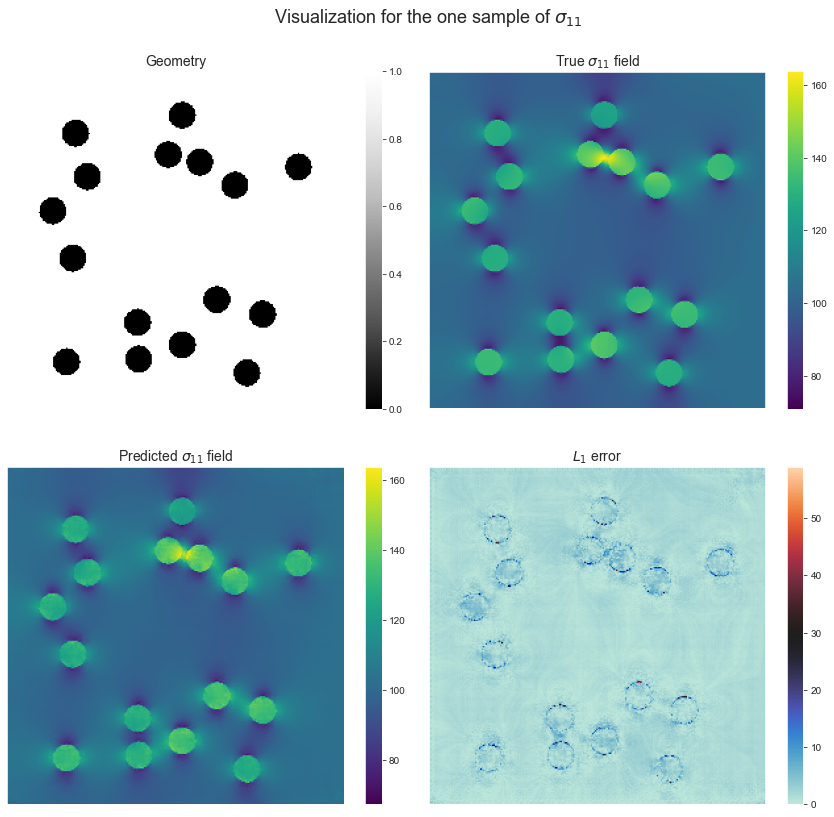

In [26]:
singular_result(test_dataloader_s11)